In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

def check(img):
  # Step 1: Initialize model with the best available weights
  weights = ResNet50_Weights.DEFAULT
  model = resnet50(weights=weights)
  model.eval()

  # Step 2: Initialize the inference transforms
  preprocess = weights.transforms()

  # Step 3: Apply inference preprocessing transforms
  batch = preprocess(img).unsqueeze(0)

  # Step 4: Use the model and print the predicted category
  prediction = model(batch).squeeze(0).softmax(0)
  class_id = prediction.argmax().item()
  score = prediction[class_id].item()
  category_name = weights.meta["categories"][class_id]
  print(f"{category_name}: {100 * score:.1f}%")
  return category_name,score


In [ ]:
from PIL import Image
check(Image.open('/home/start.png'))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Persian cat: 26.5%


('Persian cat', 0.26537108421325684)

为了处理方便，把数据标准化到[-0.5,0.5] 之间

In [ ]:
import numpy as np
from PIL import Image
min_ = 0
max_ = 255

def normalize(im):
  im = im - (min_ + max_) / 2
  im = im / (max_ - min_ )
  LB = -1/2
  UB = 1/2
  return im,LB,UB

def unnormalize(im):
  im = im * (max_ - min_)
  im = im + (min_ + max_) / 2
  return im

随机选取一部分像素点

In [ ]:
def random_locations(size,min_pixelnum):
    h = size[0]
    w = size[1]
    n = int(0.1 * h * w)
    n = min(n,min_pixelnum)
    locations = np.random.permutation(h * w)[:n]
    p_x = locations % w
    p_y = locations // w
    pxy = list(zip(p_x,p_y))
    pxy = np.array(pxy)
    return pxy

# 新段落

选择一些点，遍历每个点，对每个点进行扰动 并生成新的图像，得到一个新的图像集合

In [ ]:
# 扰动函数   r是扰动系数  r in [0,2]
def cyclic(r,Ibxy,LB,UB):
    result = r * Ibxy
    if result.any() < LB:
        result = result + (UB - LB)
    elif result.any() > UB:
        result = result - ( UB - LB )
    result = result.clip(LB,UB)
    return result

In [ ]:
# 计算整个图片列表的得分
# Img_list 的格式我们用 np.array
def score(Img_list):
  scores = []
  for im in Img_list:
    scores.append(check_array(im))
  return scores

正片开始：
- p,r 扰动系数 r in [0,2]
- R 最大迭代次数
- t 像素个数



In [ ]:
def check_array(im):
  im = Image.fromarray(im.astype(np.uint8))
  return check(im)

In [ ]:
# 我们先来扰动一张图片试一试
# 首先拉了个 pxy 出来   扰动这些点

def generate_cycliced_img_list(im,pxy):
  print('图片size：'+str(im.shape))
  print('扰动的点们：'+str(pxy.shape))
  # 首先把这些点对应的给提出来
  # 先 normalize 一下 图片
  cycliced_img_list = []
  normalized_img,LB,UB = normalize(im)
  waitcycliced_points = []
  #normalized_img
  #对每层通道都要进行扰动
  for x,y in pxy:  
    for l in range(3):
      waitcycliced_points.append(normalized_img[:,:,l][x,y])
  # len(waitcycliced_points)
  # 对这些点做整体扰动
  # waitcycliced_points
  res = cyclic(1.5,np.array(waitcycliced_points),LB,UB)
  # # len(res)
  # # 扰动好了 要再插回去
  count = 0
  num = 0
  for x,y in pxy:
    cycliced_img = normalize(im)[0]
    for l in range(3):
      cycliced_img[:,:,l][x,y] = res[count]     
      count += 1
    cycliced_img_list.append(unnormalize(cycliced_img))
  return cycliced_img_list
  
# cycliced_img_list = generate_cycliced_img_list(im,pxy)
# len(cycliced_img_list)

In [ ]:
# 选择影响力最大的t个点
def get_star_points(img_list,scores,pxy):
  sc = []
  num = 0
  for l,s in scores:
    
    success_img = Image.fromarray((img_list[num]).astype(np.uint8))
    success_img.save("/home/success.png")
    num += 1
    if l != 'tabby' and "cat" not in l :
      print('攻击成功！！！')
      print(l)
      return 0
    sc.append(float(s))

  indices = np.argsort(np.array(sc))[0:t]
  PxPy_star = pxy[indices]
  return PxPy_star

generate_cycliced_img_list(im,pxy)

In [ ]:
def localsearch(PxPy_star):
  PxPy = [(x,y) for _a,_b in PxPy_star for x in range(_a-d,_a+d+1)   for y in range(_b - d,_b+d+1    )]
  PxPy = [(x,y) for x,y in PxPy if 0<= x < w and 0<=y<h]
  PxPy = list(set(PxPy))
  PxPy = np.array(PxPy)
  return PxPy

In [ ]:
R = 30
r = 1.5
t = 5
d = 2

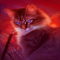

In [ ]:
# 读入图片
im = Image.open('/home/start.png')#也就是题目中给出的图片
im

In [ ]:
(h,w)= im.size
im = np.array(im)
im.shape

(60, 60, 3)

In [ ]:
def attack():
  # 初始化 (px,py) 集合   100个点
  pxy = random_locations(size=(h,w),min_pixelnum=150)
  first_list = generate_cycliced_img_list(im,pxy)
  scores = score(first_list)
  PxPy_star = get_star_points(first_list,scores,pxy)
  for i in range(R):
    print("第"+str(i+1)+"轮迭代：")
    PxPy = localsearch(PxPy_star)
    print("即将对"+str(len(PxPy))+"个点进行check")
    cycliced_img_list = generate_cycliced_img_list(im,PxPy)
    scores = score(cycliced_img_list)
    PxPy_star = get_star_points(cycliced_img_list,scores,PxPy)
attack()

图片size：(60, 60, 3)
扰动的点们：(150, 2)
Persian cat: 25.9%
Persian cat: 23.7%
Persian cat: 26.8%
Persian cat: 23.7%
Persian cat: 23.6%
Persian cat: 26.8%
Persian cat: 26.0%
Persian cat: 9.8%
Persian cat: 20.8%
Persian cat: 26.8%
Persian cat: 18.1%
Persian cat: 21.0%
Persian cat: 16.5%
Persian cat: 26.1%
Persian cat: 24.2%
Persian cat: 26.8%
Persian cat: 25.3%
Persian cat: 24.6%
Persian cat: 21.9%
Persian cat: 23.4%
Persian cat: 23.2%
Persian cat: 26.3%
Persian cat: 22.4%
Persian cat: 25.9%
Persian cat: 25.2%
Persian cat: 28.5%
Persian cat: 19.2%
Persian cat: 19.3%
Persian cat: 23.3%
Persian cat: 26.5%
Persian cat: 25.3%
Persian cat: 23.1%
Persian cat: 26.0%
Persian cat: 25.4%
Persian cat: 17.2%
Persian cat: 26.0%
Persian cat: 26.2%
Persian cat: 25.3%
Persian cat: 22.3%
Persian cat: 27.3%
Persian cat: 27.1%
Persian cat: 25.3%
Persian cat: 25.6%
Persian cat: 26.0%
Persian cat: 26.7%
Persian cat: 25.1%
Persian cat: 20.3%
Persian cat: 24.0%
Persian cat: 24.1%
Persian cat: 22.0%
Persian cat: 21.9

TypeError: ignored

In [ ]:
check(Image.open('/home/success.png'))

goldfish: 6.4%


('goldfish', 0.06421279162168503)

# 新段落